### Import packages

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import plotly.graph_objects as go
from sklearn.utils import resample
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier

import copy
import seaborn as sns
import os
from scipy import stats
import datetime

%matplotlib inline

In [2]:
data_path = '/mnt/d/lighthouse/Midterm_data/'

In [4]:
# 15927485 rows × 42
flights = pd.read_csv(data_path + 'flights.csv', header = 0, low_memory=False)
flights_test =pd.read_csv(data_path + 'flights_test.csv', header = 0)
traffic_feature = pd.read_csv(data_path + 'busy_feature.csv', header = 0)
traffic_feature.drop('Unnamed: 0', axis = 1, inplace = True)
wkey = pd.read_csv(data_path + 'wkey.csv', header = 0)
wkey.drop('Unnamed: 0', axis = 1, inplace = True)

In [5]:
# making duplicate so we dont have to re-read large csv files
flights_clean = copy.deepcopy(flights)

## Nan

In [5]:
total = flights_clean.isnull().sum().sort_values(ascending = False)
percent = (flights_clean.isnull().sum()/flights_clean.isnull().count()).sort_values(ascending = False)
missing_data = pd.concat([total,percent], axis=1, keys=['Total', 'Percent'])

In [6]:
#missing_data.head(15)

In [6]:
# dropping columsn with 80% missing AND [origin_city_name, dest_city_name] since we have [orgin, dest]
# dropping [cancelled, diverted, flights, dup] since they only contain one value
#cols_to_drop_nan = list(missing_data[missing_data['Percent'] > 0.8].index)
cols_to_drop_other = ['no_name','total_add_gtime','longest_add_gtime','first_dep_time','taxi_out','taxi_in', 'wheels_off', 'wheels_on', 'flights', 'dup']
flights_clean.drop(cols_to_drop_other, axis = 1, inplace = True)
flights_test.drop(['dup','flights'], axis =1, inplace=True)

## rows with Nan

In [33]:
# before: (15927485, 20)
# after: 15652397 rows × 20 columns
# lost 3% of data, no biggie
#flights_clean.dropna(inplace = True)

### fl_date to year/month/day

In [7]:
flights_clean['fl_date'] = pd.to_datetime(flights_clean['fl_date'])
flights_clean['year'] = flights_clean['fl_date'].dt.year
flights_clean['month'] = flights_clean['fl_date'].dt.month
flights_clean['day'] = flights_clean['fl_date'].dt.day
# Dropping the old date column
flights_clean.drop('fl_date', axis = 1, inplace = True)

In [13]:
flights_clean.head()

,mkt_unique_carrier,branded_code_share,mkt_carrier_fl_num,tail_num,origin,dest,crs_dep_time,dep_delay,crs_arr_time,arr_delay,...,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,year,month,day,total_flights
0,WN,WN,2098,N8540V,MCI,PHX,1755,-2.0,1850,-12.0,...,1044,NaN,NaN,NaN,NaN,NaN,2019,3,25,226679
1,WN,WN,2238,N8656B,MCI,PHX,2000,-5.0,2055,-19.0,...,1044,NaN,NaN,NaN,NaN,NaN,2019,3,25,226679
2,WN,WN,2451,N8583Z,MCI,PHX,540,1.0,635,-10.0,...,1044,NaN,NaN,NaN,NaN,NaN,2019,3,25,226679
3,WN,WN,2213,N737JW,MCI,RDU,1550,99.0,1905,94.0,...,904,1.0,0.0,0.0,0.0,93.0,2019,3,25,226679
4,WN,WN,2096,N705SW,MCI,RSW,1045,166.0,1430,152.0,...,1155,152.0,0.0,0.0,0.0,0.0,2019,3,25,226679


In [9]:
flights_clean.drop(['mkt_carrier','op_unique_carrier','op_carrier_fl_num','origin_airport_id','origin_city_name','dest_airport_id','dest_city_name','dep_time','arr_time','actual_elapsed_time','crs_elapsed_time'], axis = 1, inplace = True)

### merging traffic feature

In [11]:
traffic_feature.head()

,origin,total_flights
0,ORD,1580382
1,ATL,1571735
2,DFW,1169290
3,DEN,1104315
4,CLT,1003049


In [12]:
flights_clean = flights_clean.merge(traffic_feature, on=['origin'], how='left')

### merging weather features

In [14]:
wkey.head()

,origin,month,latitude,longitude,wdir,period,temp,maxt,visibility,wspd,...,mint,precip,snowdepth,sealevelpressure,dew,humidity,wgust,precipcover,windchill,closest_airport
0,LAX,1,33.94254,-118.40807,155.18,Jan,59.3,87.8,8.7,31.4,...,40.0,6.98,NaN,1018.8,44.4,64.04,40.0,7.40,35.2,LAX
1,SFO,1,37.61900,-122.37484,155.18,Jan,59.3,87.8,8.7,31.4,...,40.0,6.98,NaN,1018.8,44.4,64.04,40.0,7.40,35.2,LAX
2,SAN,1,32.73356,-117.18966,155.18,Jan,59.3,87.8,8.7,31.4,...,40.0,6.98,NaN,1018.8,44.4,64.04,40.0,7.40,35.2,LAX
3,SEA,1,47.44898,-122.30931,175.30,Jan,35.7,59.1,7.9,26.4,...,19.1,2.37,NaN,1020.7,29.9,80.47,44.7,6.59,13.4,YKM
4,RDU,1,35.87764,-78.78747,215.02,Jan,32.8,70.0,9.1,35.8,...,-0.9,5.37,3.6,1021.9,21.7,66.20,50.8,9.01,-10.1,IAD


In [15]:
flights_clean = flights_clean.merge(wkey, on=['origin','month'], how='left')

# FILE TO CSV CHECKPOINT

In [ ]:
#flights_clean.to_csv('/mnt/d/lighthouse/Midterm_data/model_multiclass_traffic_weather.csv')

In [3]:
flights_test = pd.read_csv(data_path + 'flights_test.csv', header = 0)
flights_clean = pd.read_csv(data_path + 'model_multiclass_traffic_weather.csv', header = 0)
flights_clean.drop('Unnamed: 0', axis = 1, inplace = True)

/home/david/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
flights_test.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,crs_arr_time,dup,crs_elapsed_time,flights,distance
0,2019-12-31 23:00:00,WN,WN,WN,5888,WN,N951WN,5888,13891,ONT,"Ontario, CA",14771,SFO,"San Francisco, CA",1810,1945,N,95,1,363
1,2019-12-31 23:00:00,WN,WN,WN,6276,WN,N467WN,6276,13891,ONT,"Ontario, CA",14771,SFO,"San Francisco, CA",1150,1320,N,90,1,363
2,2019-12-31 23:00:00,WN,WN,WN,4598,WN,N7885A,4598,13891,ONT,"Ontario, CA",14831,SJC,"San Jose, CA",2020,2130,N,70,1,333
3,2019-12-31 23:00:00,WN,WN,WN,4761,WN,N551WN,4761,13891,ONT,"Ontario, CA",14831,SJC,"San Jose, CA",1340,1455,N,75,1,333
4,2019-12-31 23:00:00,WN,WN,WN,5162,WN,N968WN,5162,13891,ONT,"Ontario, CA",14831,SJC,"San Jose, CA",915,1035,N,80,1,333


In [7]:
flights_clean.head()

,mkt_unique_carrier,branded_code_share,mkt_carrier_fl_num,tail_num,origin,dest,crs_dep_time,dep_delay,crs_arr_time,arr_delay,...,mint,precip,snowdepth,sealevelpressure,dew,humidity,wgust,precipcover,windchill,closest_airport
0,WN,WN,2098,N8540V,MCI,PHX,1755,-2.0,1850,-12.0,...,-9.0,4.7,NaN,1020.2,26.9,77.1,57.5,6.86,-30.4,SUX
1,WN,WN,2238,N8656B,MCI,PHX,2000,-5.0,2055,-19.0,...,-9.0,4.7,NaN,1020.2,26.9,77.1,57.5,6.86,-30.4,SUX
2,WN,WN,2451,N8583Z,MCI,PHX,540,1.0,635,-10.0,...,-9.0,4.7,NaN,1020.2,26.9,77.1,57.5,6.86,-30.4,SUX
3,WN,WN,2213,N737JW,MCI,RDU,1550,99.0,1905,94.0,...,-9.0,4.7,NaN,1020.2,26.9,77.1,57.5,6.86,-30.4,SUX
4,WN,WN,2096,N705SW,MCI,RSW,1045,166.0,1430,152.0,...,-9.0,4.7,NaN,1020.2,26.9,77.1,57.5,6.86,-30.4,SUX


In [26]:
# over represented
flights_over = flights_clean[(np.isnan(flights_clean['carrier_delay'])==True)&(np.isnan(flights_clean['weather_delay'])==True)&(np.isnan(flights_clean['nas_delay'])==True)&(np.isnan(flights_clean['security_delay'])==True)&(np.isnan(flights_clean['late_aircraft_delay'])==True)]

In [85]:
# under represented
flights_under = copy.deepcopy(flights_clean[(np.isnan(flights_clean['carrier_delay'])==False)&(np.isnan(flights_clean['weather_delay'])==False)&(np.isnan(flights_clean['nas_delay'])==False)&(np.isnan(flights_clean['security_delay'])==False)&(np.isnan(flights_clean['late_aircraft_delay'])==False)])

In [86]:
test = copy.deepcopy(flights_under[['carrier_delay','weather_delay','nas_delay','security_delay','late_aircraft_delay']])

In [87]:
test['highest_delay'] = test.idxmax(axis=1)

In [90]:
#test[(test['carrier_delay']==0)&(test['weather_delay']==0)&(test['nas_delay']==0)&(test['security_delay']==0)&(test['late_aircraft_delay']==0)]

,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,highest_delay
6379695,0.0,0.0,0.0,0.0,0.0,0
9164709,0.0,0.0,0.0,0.0,0.0,0


In [89]:
test.loc[[6379695,9164709], 'highest_delay'] = 0

In [91]:
# 0 = no delay
# 1 = carrier_delay
# 2 = weather_delay
# 3 = nas_delay
# 4 = security_delay
# 5 = late_aircraft_delay
test['delay_type'] = np.where(test['highest_delay']=='carrier_delay',1,
                             np.where(test['highest_delay']=='weather_delay',2,
                                     np.where(test['highest_delay']=='nas_delay',3,
                                             np.where(test['highest_delay']=='security_delay',4,
                                                     np.where(test['highest_delay']=='late_aircraft_delay',5,0)))))

In [92]:
test

,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,highest_delay,delay_type
3,1.0,0.0,0.0,0.0,93.0,late_aircraft_delay,5
4,152.0,0.0,0.0,0.0,0.0,carrier_delay,1
13,44.0,0.0,0.0,0.0,0.0,carrier_delay,1
17,0.0,0.0,82.0,0.0,0.0,nas_delay,3
31,2.0,0.0,0.0,0.0,14.0,late_aircraft_delay,5
...,...,...,...,...,...,...,...
15927447,148.0,0.0,0.0,0.0,0.0,carrier_delay,1
15927463,74.0,0.0,0.0,0.0,60.0,carrier_delay,1
15927467,103.0,0.0,0.0,0.0,7.0,carrier_delay,1
15927476,3.0,0.0,0.0,0.0,30.0,late_aircraft_delay,5


In [93]:
flights_under['delay_type'] = test['delay_type']

In [94]:
flights_under.drop(['carrier_delay','weather_delay','nas_delay', 'security_delay','late_aircraft_delay'], axis = 1, inplace = True)

In [101]:
flights_under.head()

,mkt_unique_carrier,branded_code_share,mkt_carrier_fl_num,tail_num,origin,dest,crs_dep_time,dep_delay,crs_arr_time,arr_delay,...,precip,sealevelpressure,dew,humidity,wgust,precipcover,windchill,closest_airport,delay_type,snow_type
3,WN,WN,2213,N737JW,MCI,RDU,1550,99.0,1905,94.0,...,4.70,1020.2,26.9,77.10,57.5,6.86,-30.4,SUX,5,0.0
4,WN,WN,2096,N705SW,MCI,RSW,1045,166.0,1430,152.0,...,4.70,1020.2,26.9,77.10,57.5,6.86,-30.4,SUX,1,0.0
13,WN,WN,966,N267WN,MCI,TPA,805,55.0,1140,44.0,...,4.70,1020.2,26.9,77.10,57.5,6.86,-30.4,SUX,1,0.0
17,WN,WN,167,N270WN,MCO,ATL,1940,68.0,2115,82.0,...,1.58,1019.3,54.4,67.86,43.6,3.36,33.9,PGD,3,0.0
31,WN,WN,792,N488WN,MCO,BNA,910,23.0,1010,16.0,...,1.58,1019.3,54.4,67.86,43.6,3.36,33.9,PGD,5,0.0


### Fixing and dropping some features

### Snowdepth

In [96]:
flights_under['snow_type'] = np.where(3<=flights_under['snowdepth'],2,flights_under['snowdepth'])
flights_under['snow_type'] = np.where((flights_under['snowdepth']<3)&(1<=flights_under['snowdepth']),1,flights_under['snow_type'])
flights_under['snow_type'] = np.where((flights_under['snow_type']==2)|(flights_under['snow_type']==1),flights_under['snow_type'],0)

In [97]:
flights_under.drop('snowdepth', axis = 1, inplace = True)

### imputing missing values

In [107]:
total = flights_under.isnull().sum().sort_values(ascending = False)
percent = (flights_under.isnull().sum()/flights_under.isnull().count()).sort_values(ascending = False)
missing_data = pd.concat([total,percent], axis=1, keys=['Total', 'Percent'])

In [108]:
missing_data.head(8)

,Total,Percent
cancellation_code,3009484,1.0
snow_type,0,0.0
delay_type,0,0.0
day,0,0.0
month,0,0.0
year,0,0.0
distance,0,0.0
air_time,0,0.0


In [106]:
flights_under['windchill'] = flights_under['windchill'].fillna(np.mean(flights_under['windchill']))
flights_under['heatindex'] = flights_under['heatindex'].fillna(np.mean(flights_under['heatindex']))
flights_under['sealevelpressure'] = flights_under['sealevelpressure'].fillna(np.mean(flights_under['sealevelpressure']))
flights_under['wgust'] = flights_under['wgust'].fillna(np.mean(flights_under['wgust']))
flights_under['air_time'] = flights_under['air_time'].fillna(np.mean(flights_under['air_time']))
flights_under['dep_delay'] = flights_under['dep_delay'].fillna(np.mean(flights_under['dep_delay']))

### mean_tail_num_delay

In [111]:
flights_final = pd.read_csv(data_path + 'model_weather_traffic.csv', header = 0, low_memory=False)
flights_final.drop('Unnamed: 0', axis =1, inplace =True)

In [112]:
flights_FE = copy.deepcopy(flights_final)
flights_FE = flights_FE[(flights_FE['dep_delay']>0) | (flights_FE['arr_delay']>0)]

In [113]:
delay_df = flights_FE.groupby('tail_num').mean()[['arr_delay','dep_delay']]
delay_df.reset_index(inplace=True)
delay_df.columns = ['tail_num','mean_tail_num_arr_delay','mean_tail_num_dep_delay']
delay_df

,tail_num,mean_tail_num_arr_delay,mean_tail_num_dep_delay
0,215NV,33.043988,31.904203
1,216NV,36.282759,33.558621
2,217NV,43.742410,41.177553
3,218NV,38.836638,36.399433
4,219NV,39.116352,37.131027
...,...,...,...
6473,N999DN,23.850977,25.293160
6474,N999FR,25.375000,18.750000
6475,N999JB,21.244186,22.813953
6476,N999JQ,41.288714,45.611549


In [114]:
flights_under = flights_under.merge(delay_df, on=['tail_num'], how='left')

### mean_carrier_delay

In [116]:
carrier_delay = flights_FE.groupby('mkt_unique_carrier').mean()[['arr_delay','dep_delay']]
carrier_delay.reset_index(inplace=True)
carrier_delay.columns = ['mkt_unique_carrier','mean_carrier_arr_delay','mean_carrier__dep_delay']
carrier_delay

,mkt_unique_carrier,mean_carrier_arr_delay,mean_carrier__dep_delay
0,AA,31.420120,29.823116
1,AS,21.034051,18.238872
2,B6,40.321600,41.194944
3,DL,30.814713,31.867638
4,F9,37.903671,39.483474
5,G4,37.406556,35.583511
6,HA,15.450311,12.976746
7,NK,33.288398,33.350894
8,UA,41.523520,38.614889
9,VX,24.528221,22.637083


In [117]:
flights_under = flights_under.merge(carrier_delay, on=['mkt_unique_carrier'], how='left')

In [118]:
flights_under.head()

,mkt_unique_carrier,branded_code_share,mkt_carrier_fl_num,tail_num,origin,dest,crs_dep_time,dep_delay,crs_arr_time,arr_delay,...,wgust,precipcover,windchill,closest_airport,delay_type,snow_type,mean_tail_num_arr_delay,mean_tail_num_dep_delay,mean_carrier_arr_delay,mean_carrier__dep_delay
0,WN,WN,2213,N737JW,MCI,RDU,1550,99.0,1905,94.0,...,57.5,6.86,-30.4,SUX,5,0.0,17.657185,22.203531,17.308595,22.411967
1,WN,WN,2096,N705SW,MCI,RSW,1045,166.0,1430,152.0,...,57.5,6.86,-30.4,SUX,1,0.0,19.461314,24.219465,17.308595,22.411967
2,WN,WN,966,N267WN,MCI,TPA,805,55.0,1140,44.0,...,57.5,6.86,-30.4,SUX,1,0.0,16.905995,21.475779,17.308595,22.411967
3,WN,WN,167,N270WN,MCO,ATL,1940,68.0,2115,82.0,...,43.6,3.36,33.9,PGD,3,0.0,18.516084,22.934732,17.308595,22.411967
4,WN,WN,792,N488WN,MCO,BNA,910,23.0,1010,16.0,...,43.6,3.36,33.9,PGD,5,0.0,19.883171,24.254057,17.308595,22.411967


# READ CHECKPOINT FILE HERE!!!

In [3]:
flights_under = pd.read_csv('checkpoint.csv',header = 0)
flights_under.drop('Unnamed: 0', axis = 1, inplace = True)

In [4]:
flights_under.head()

,mkt_unique_carrier,branded_code_share,mkt_carrier_fl_num,tail_num,origin,dest,crs_dep_time,dep_delay,crs_arr_time,arr_delay,...,wgust,precipcover,windchill,closest_airport,delay_type,snow_type,mean_tail_num_arr_delay,mean_tail_num_dep_delay,mean_carrier_arr_delay,mean_carrier__dep_delay
0,WN,WN,2213,N737JW,MCI,RDU,1550,99.0,1905,94.0,...,57.5,6.86,-30.4,SUX,5,0.0,17.657185,22.203531,17.308595,22.411967
1,WN,WN,2096,N705SW,MCI,RSW,1045,166.0,1430,152.0,...,57.5,6.86,-30.4,SUX,1,0.0,19.461314,24.219465,17.308595,22.411967
2,WN,WN,966,N267WN,MCI,TPA,805,55.0,1140,44.0,...,57.5,6.86,-30.4,SUX,1,0.0,16.905995,21.475779,17.308595,22.411967
3,WN,WN,167,N270WN,MCO,ATL,1940,68.0,2115,82.0,...,43.6,3.36,33.9,PGD,3,0.0,18.516084,22.934732,17.308595,22.411967
4,WN,WN,792,N488WN,MCO,BNA,910,23.0,1010,16.0,...,43.6,3.36,33.9,PGD,5,0.0,19.883171,24.254057,17.308595,22.411967


### Correlated values

In [8]:
df_corr = flights_under.corr().abs()
indices = np.where(df_corr > 0.8) 
indices = [(df_corr.index[x], df_corr.columns[y]) for x, y in zip(*indices) if x != y and x < y]
indices

[('dep_delay', 'arr_delay'),
 ('air_time', 'distance'),
 ('temp', 'maxt'),
 ('temp', 'mint'),
 ('temp', 'dew'),
 ('maxt', 'mint'),
 ('maxt', 'dew'),
 ('mint', 'dew'),
 ('mean_tail_num_arr_delay', 'mean_tail_num_dep_delay'),
 ('mean_carrier_arr_delay', 'mean_carrier__dep_delay')]

In [5]:
flights_under.drop(['air_time','maxt','mint','dew','mean_tail_num_dep_delay', 'mean_carrier__dep_delay', 'mkt_unique_carrier', 'tail_num','closest_airport', 'period', 'cancellation_code'], axis = 1, inplace = True)

In [6]:
flights_under

,branded_code_share,mkt_carrier_fl_num,origin,dest,crs_dep_time,dep_delay,crs_arr_time,arr_delay,cancelled,diverted,...,precip,sealevelpressure,humidity,wgust,precipcover,windchill,delay_type,snow_type,mean_tail_num_arr_delay,mean_carrier_arr_delay
0,WN,2213,MCI,RDU,1550,99.0,1905,94.0,0,0,...,4.70,1020.2,77.10,57.5,6.86,-30.4,5,0.0,17.657185,17.308595
1,WN,2096,MCI,RSW,1045,166.0,1430,152.0,0,0,...,4.70,1020.2,77.10,57.5,6.86,-30.4,1,0.0,19.461314,17.308595
2,WN,966,MCI,TPA,805,55.0,1140,44.0,0,0,...,4.70,1020.2,77.10,57.5,6.86,-30.4,1,0.0,16.905995,17.308595
3,WN,167,MCO,ATL,1940,68.0,2115,82.0,0,0,...,1.58,1019.3,67.86,43.6,3.36,33.9,3,0.0,18.516084,17.308595
4,WN,792,MCO,BNA,910,23.0,1010,16.0,0,0,...,1.58,1019.3,67.86,43.6,3.36,33.9,5,0.0,19.883171,17.308595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3009479,WN,2217,MCI,DEN,510,152.0,600,148.0,0,0,...,4.70,1020.2,77.10,57.5,6.86,-30.4,1,0.0,15.743798,17.308595
3009480,WN,2025,MCI,LAX,1315,139.0,1455,134.0,0,0,...,4.70,1020.2,77.10,57.5,6.86,-30.4,1,0.0,20.341119,17.308595
3009481,WN,2211,MCI,MCO,900,114.0,1235,110.0,0,0,...,4.70,1020.2,77.10,57.5,6.86,-30.4,1,0.0,17.242902,17.308595
3009482,WN,1600,MCI,MKE,1250,39.0,1415,33.0,0,0,...,4.70,1020.2,77.10,57.5,6.86,-30.4,5,0.0,17.288433,17.308595


In [7]:
flights_under = flights_under[flights_under.delay_type != 0]

Text(0.5, 1.0, 'count of each type of delay')

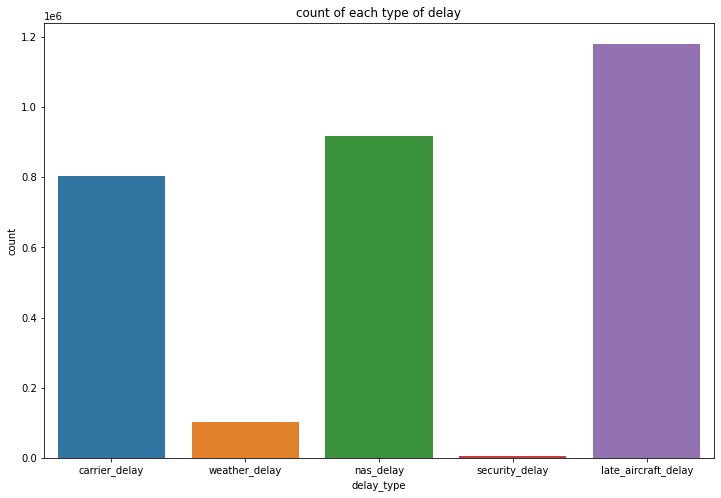

In [8]:
fig, ax = plt.subplots(figsize=(12,8))
sns.countplot(flights_under['delay_type'])
ax.set(xticklabels=['carrier_delay','weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay'])
ax.set_title('count of each type of delay')
#plt.savefig('/mnt/d/lighthouse/Midterm/visualization/model_multiclass_delay_count.png')

In [9]:
# 0 = no delay (2)
# 1 = carrier_delay (805007)
# 2 = weather_delay (101407)
# 3 = nas_delay (917490)
# 4 = security_delay (5141)
# 5 = late_aircraft_delay (1180437)

In [10]:
delay_1 = flights_under[flights_under['delay_type']==1]
delay_2 = flights_under[flights_under['delay_type']==2]
delay_3 = flights_under[flights_under['delay_type']==3]
delay_4 = flights_under[flights_under['delay_type']==4]
delay_5 = flights_under[flights_under['delay_type']==5]

In [11]:
boot_1 = resample(delay_1, replace=True, n_samples=290000)
boot_2 = resample(delay_2, replace=True, n_samples=900000)
boot_3 = resample(delay_3, replace=True, n_samples=200000)
boot_4 = resample(delay_4, replace=True, n_samples=900000)

In [12]:
flight_balanced=pd.concat([flights_under,boot_1,boot_2,boot_3,boot_4])

Text(0.5, 1.0, 'count of each type of delay')

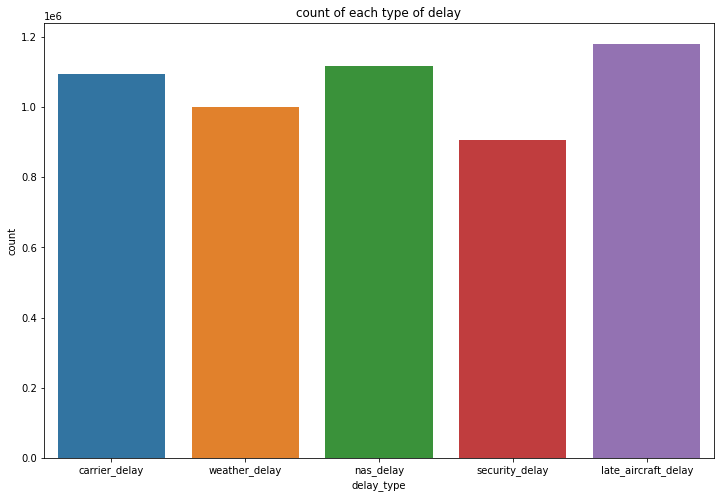

In [13]:
fig, ax = plt.subplots(figsize=(12,8))
sns.countplot(flight_balanced['delay_type'])
ax.set(xticklabels=['carrier_delay','weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay'])
ax.set_title('count of each type of delay')
#plt.savefig('/mnt/d/lighthouse/Midterm/visualization/model_multiclass_delay_count.png')

In [162]:
# 5649482 rows × 33 columns
flight_balanced

,branded_code_share,mkt_carrier_fl_num,origin,dest,crs_dep_time,dep_delay,crs_arr_time,arr_delay,cancelled,diverted,...,precip,sealevelpressure,humidity,wgust,precipcover,windchill,delay_type,snow_type,mean_tail_num_arr_delay,mean_carrier_arr_delay
0,WN,2213,MCI,RDU,1550,99.0,1905,94.0,0,0,...,4.70,1020.2,77.10,57.5,6.86,-30.400000,5,0.0,17.657185,17.308595
1,WN,2096,MCI,RSW,1045,166.0,1430,152.0,0,0,...,4.70,1020.2,77.10,57.5,6.86,-30.400000,1,0.0,19.461314,17.308595
2,WN,966,MCI,TPA,805,55.0,1140,44.0,0,0,...,4.70,1020.2,77.10,57.5,6.86,-30.400000,1,0.0,16.905995,17.308595
3,WN,167,MCO,ATL,1940,68.0,2115,82.0,0,0,...,1.58,1019.3,67.86,43.6,3.36,33.900000,3,0.0,18.516084,17.308595
4,WN,792,MCO,BNA,910,23.0,1010,16.0,0,0,...,1.58,1019.3,67.86,43.6,3.36,33.900000,5,0.0,19.883171,17.308595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2970545,AA,662,CLT,LAX,1610,48.0,1841,57.0,0,0,...,6.25,1018.1,58.60,71.4,8.34,2.800000,4,2.0,21.957746,31.420120
2525231,WN,3809,STL,TPA,1615,76.0,1930,69.0,0,0,...,9.28,1016.0,76.73,48.1,4.37,18.798078,4,0.0,19.559433,17.308595
242767,G4,1671,RFD,PGD,923,30.0,1311,20.0,0,0,...,1.30,1022.5,75.79,65.5,2.08,-43.400000,4,0.0,31.124108,37.406556
2085187,AA_CODESHARE,3568,CVG,MIA,600,21.0,839,17.0,0,0,...,13.56,1015.6,73.19,57.5,10.62,41.300000,4,0.0,30.108758,31.420120


In [14]:
flight_balanced['branded_code_share'] = pd.factorize(flight_balanced['branded_code_share'])[0]
flight_balanced['mkt_carrier_fl_num'] = pd.factorize(flight_balanced['mkt_carrier_fl_num'])[0]
flight_balanced['origin'] = pd.factorize(flight_balanced['origin'])[0]
flight_balanced['dest'] = pd.factorize(flight_balanced['dest'])[0]

In [28]:
flight_balanced.head()

,branded_code_share,mkt_carrier_fl_num,origin,dest,crs_dep_time,dep_delay,crs_arr_time,arr_delay,cancelled,diverted,...,precip,sealevelpressure,humidity,wgust,precipcover,windchill,delay_type,snow_type,mean_tail_num_arr_delay,mean_carrier_arr_delay
0,0,0,0,0,1550,99.0,1905,94.0,0,0,...,4.70,1020.2,77.10,57.5,6.86,-30.4,5,0.0,17.657185,17.308595
1,0,1,0,1,1045,166.0,1430,152.0,0,0,...,4.70,1020.2,77.10,57.5,6.86,-30.4,1,0.0,19.461314,17.308595
2,0,2,0,2,805,55.0,1140,44.0,0,0,...,4.70,1020.2,77.10,57.5,6.86,-30.4,1,0.0,16.905995,17.308595
3,0,3,1,3,1940,68.0,2115,82.0,0,0,...,1.58,1019.3,67.86,43.6,3.36,33.9,3,0.0,18.516084,17.308595
4,0,4,1,4,910,23.0,1010,16.0,0,0,...,1.58,1019.3,67.86,43.6,3.36,33.9,5,0.0,19.883171,17.308595


### Scaling

In [15]:
numericals = ['crs_dep_time','crs_arr_time','distance','total_flights','wdir','temp','visibility','wspd','heatindex','cloudcover','precip','sealevelpressure','humidity','wgust','precipcover','windchill','mean_tail_num_arr_delay','mean_carrier_arr_delay']

In [16]:
num_scaled = StandardScaler().fit_transform(flight_balanced[numericals])

In [17]:
for i in range(len(numericals)):
    flight_balanced[numericals[i]] = num_scaled[:,i]

In [18]:
flight_balanced.head()

,branded_code_share,mkt_carrier_fl_num,origin,dest,crs_dep_time,dep_delay,crs_arr_time,arr_delay,cancelled,diverted,...,precip,sealevelpressure,humidity,wgust,precipcover,windchill,delay_type,snow_type,mean_tail_num_arr_delay,mean_carrier_arr_delay
0,0,0,0,0,0.254917,99.0,0.617254,94.0,0,0,...,-0.397772,1.181165,0.873326,1.163198,0.292976,-2.580798,5,0.0,-1.236046,-1.620762
1,0,1,0,1,-0.795835,166.0,-0.282287,152.0,0,0,...,-0.397772,1.181165,0.873326,1.163198,0.292976,-2.580798,1,0.0,-1.072000,-1.620762
2,0,2,0,2,-1.295202,55.0,-0.831480,44.0,0,0,...,-0.397772,1.181165,0.873326,1.163198,0.292976,-2.580798,1,0.0,-1.304350,-1.620762
3,0,3,1,3,1.066388,68.0,1.014945,82.0,0,0,...,-0.950996,0.854514,-0.436103,-0.202066,-0.724478,0.797318,3,0.0,-1.157948,-1.620762
4,0,4,1,4,-1.076729,23.0,-1.077670,16.0,0,0,...,-0.950996,0.854514,-0.436103,-0.202066,-0.724478,0.797318,5,0.0,-1.033641,-1.620762


In [173]:
#flight_balanced.to_csv('/mnt/d/lighthouse/Midterm_data/model_balanced.csv')

# Model

In [7]:
#flights_final = pd.read_csv(data_path + 'model_1_encode_only.csv', header = 0)
#flights_final.drop('Unnamed: 0', axis = 1, inplace= True)

In [8]:
#flights_test =pd.read_csv(data_path + 'flights_test.csv', header = 0)
#flights_test.drop(['dup','flights'], axis =1, inplace=True)
#flights_test['fl_date'] = pd.to_datetime(flights_test['fl_date'])
#flights_test['year'] = flights_test['fl_date'].dt.year
#flights_test['month'] = flights_test['fl_date'].dt.month
#flights_test['date'] = flights_test['fl_date'].dt.day
# Dropping the old date column
#flights_test.drop('fl_date', axis = 1, inplace = True)

### test train split

In [44]:
X.columns

Index(['branded_code_share', 'mkt_carrier_fl_num', 'origin', 'dest',
       'crs_dep_time', 'dep_delay', 'crs_arr_time', 'arr_delay', 'cancelled',
       'diverted', 'distance', 'year', 'month', 'day', 'total_flights',
       'latitude', 'longitude', 'wdir', 'temp', 'visibility', 'wspd',
       'heatindex', 'cloudcover', 'precip', 'sealevelpressure', 'humidity',
       'wgust', 'precipcover', 'windchill', 'snow_type',
       'mean_tail_num_arr_delay', 'mean_carrier_arr_delay'],
      dtype='object')

In [19]:
X = flight_balanced.drop('delay_type', axis = 1)
y = flight_balanced['delay_type']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)

### BaggingClassifier

In [24]:
clf_bal = BaggingClassifier(n_estimators=20, random_state=0)
clf_bal.fit(X_train, y_train)
y_pred=clf_bal.predict(X_test)
# Confusion Matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[236506,   6345,   7988,    368,  77329],
       [   146, 300089,     11,      0,     79],
       [ 20262,   3135, 286254,    124,  25474],
       [     0,      0,      0, 271816,      0],
       [ 90945,   9677,  15999,    420, 236878]])

In [25]:
print ("accuracy: ", metrics.accuracy_score(y_test, y_pred))
#print("Precision:",metrics.precision_score(y_test, y_pred))
#print("Recall:",metrics.recall_score(y_test, y_pred))

accuracy:  0.8375300736864285


### XGB classifier

In [21]:
xg_class = xgb.XGBClassifier(n_estimators = 10, n_jobs = -1)

In [22]:
xg_class.fit(X_train,y_train)
y_pred = xg_class.predict(X_test)
print(metrics.accuracy_score(y_test,y_pred))

0.5303271702587359


In [23]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[ 96043,  59240,   6051,  52286, 114916],
       [ 45349, 138294,   8171,  22480,  86031],
       [ 14570,  21752, 247090,  10116,  41721],
       [ 32537,  21955,   2792, 144223,  70309],
       [ 47303,  52464,   5820,  30844, 217488]])

### Naive Bayes

In [39]:
gnb = GaussianNB()

In [40]:
gnb.fit(X_train, y_train) 

GaussianNB()

In [41]:
y_pred = gnb.predict(X_test)

In [42]:
metrics.accuracy_score(y_test,y_pred)

0.3329720821841123

In [43]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[ 13518,  46790, 116707,  83168,  68353],
       [ 12958,  86757,  89544,  40708,  70358],
       [  4591,  30129, 181157,  71819,  47553],
       [  8341,  17040,  74434, 133439,  38562],
       [ 11079,  45422,  99169,  83746, 114503]])

### Adaboosting naive bayes

In [35]:
naive = GaussianNB()
ada_naive = AdaBoostClassifier(base_estimator=naive)
ada_naive.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=GaussianNB())

In [36]:
y_pred = ada_naive.predict(X_test)

In [38]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[187961,  17212,  45783,  51381,  26199],
       [177985,  22637,  48387,  33217,  18099],
       [181858,  16336,  54616,  55710,  26729],
       [147124,   8780,  33683,  57405,  24824],
       [198203,  19225,  51401,  52185,  32905]])

In [37]:
print(metrics.accuracy_score(y_test,y_pred))

0.22362179960939588
